# Feature Selection for predicting diabetes using Particle swarm optimization

The code below shows how Particle Swarm Optimisation(PSO) is used to predict diabetes through the application of Feature Selection.

**Import the libraries**

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning models and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


Import the **"Pima Indian diabetes dataset"** from Kaggle

The test problem we will use in this repository is the Pima Indians Diabetes problem taken from Machine Learning Repository UCI: https://www.kaggle.com/api/v1/datasets/download/uciml/pima-indians-diabetes-database?dataset_version_number=1.

* This problem is comprised of 768 observations of medical details for Pima indians patents.
* The records describe instantaneous measurements taken from the patient such as their age, the number of times pregnant and blood workup.
* All patients are women aged 21 or older. All attributes are numeric, and their units vary from attribute to attribute.
* Each record has a class value that indicates whether the patient suffered an onset of diabetes within 5 years of when the measurements were taken (1) or not (0).





---



In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
print("Path to dataset files:", path)

100%|██████████| 8.91k/8.91k [00:00<00:00, 12.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/uciml/pima-indians-diabetes-database/versions/1


In [3]:
!unzip archive.zip

Archive:  archive.zip
  inflating: diabetes.csv            


The outcome tested was Diabetes, 258 tested positive and 500 tested negative. Therefore, there is one target (dependent) variable and the following attributes:

* Pregnancies (number of times pregnant),

* Oral glucose tolerance test - OGTT (two hour plasma glucose concentration after 75g anhydrous glucose in mg/dl),

* Blood Pressure (Diastolic Blood Pressure in mmHg),

* Skin Thickness (Triceps skin fold thickness in mm),

* Insulin (2 h serum insulin in mu U/ml),

* BMI (Body Mass Index in kg/m2),

*  Age (years),

* Pedigree Diabetes Function ('function that represents how likely they are to get the disease by extrapolating from their ancestor’s history')

In [4]:
data = pd.read_csv("diabetes.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


**Data Visualization**

Data visualization plays a crucial role in this project by helping us understand the data, evaluate model performance, and communicate results effectively. A **correlation heatmap** helps visualize relationships between features, aiding in feature selection by highlighting redundancies. To assess model performance, we plot **training and validation error curves** for **XGBoost** and **cross-validation accuracy plots** for **Random Forest**. These help track overfitting and assess generalization. Additionally, we visualize the impact of **PSO**, **IPSO**, and **PSO-LS** feature selection techniques on model performance, using **bar charts** to compare accuracy, precision, recall, and F1 scores. These visualizations enhance the clarity of our findings and demonstrate the effectiveness of different feature selection methods in improving predictive performance.

In [5]:
# Preprocessing and Data Visualization

# Display the first few rows
print(data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [6]:
# Check for missing values
print("\nMissing values per column:\n", data.isnull().sum())


Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [7]:
# Replace 0 values in features where 0 is not a valid value (like 'Glucose', 'BloodPressure', etc.)
# We'll replace these 0 values with NaN to fill them later
data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = data[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)


In [8]:
# Fill missing values with the median of each column
data.fillna(data.median(), inplace=True)


In [9]:
# Check again for missing values
print("\nMissing values after handling:\n", data.isnull().sum())


Missing values after handling:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [10]:
# Summary statistics to understand the dataset better
print("\nDataset statistics:\n", data.describe())


Dataset statistics:
        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073  140.671875   
std       3.369578   30.438286      12.096642       8.791221   86.383060   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.455208                  0.471876   33.240885    0.348958  
std      6.875177                  0.331329   11.760232    0.476951  
min     18.20

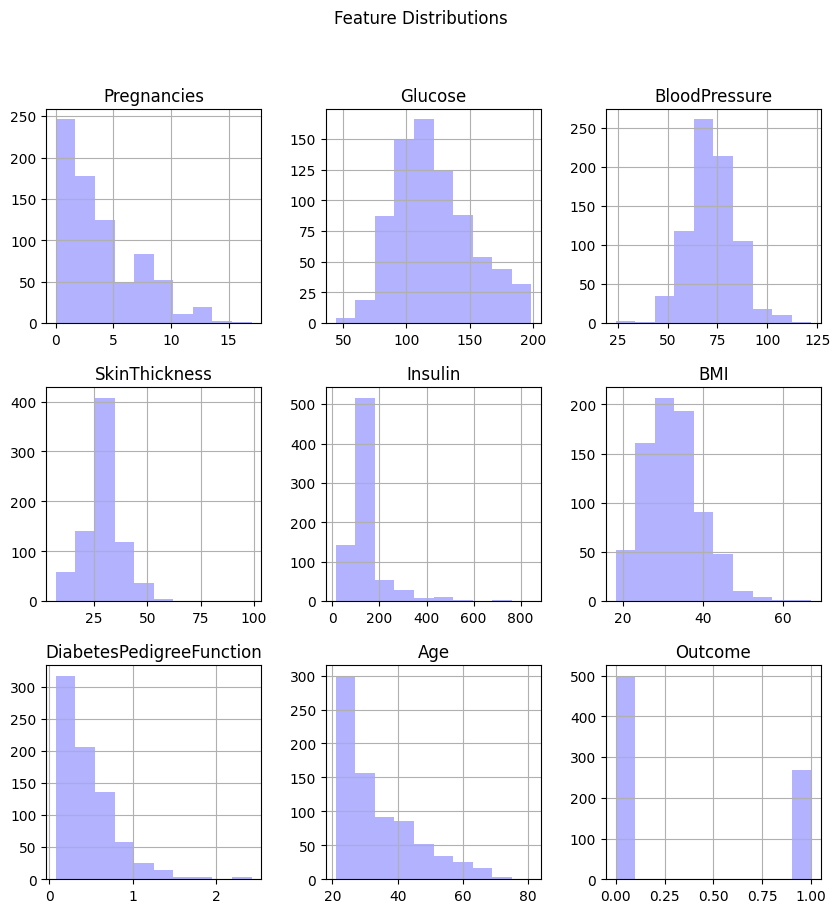

In [16]:
# 1. Histogram for each feature to understand the distribution
data.hist(bins=10, figsize=(10, 10), color='blue', alpha=0.3)
plt.suptitle('Feature Distributions')
plt.show()


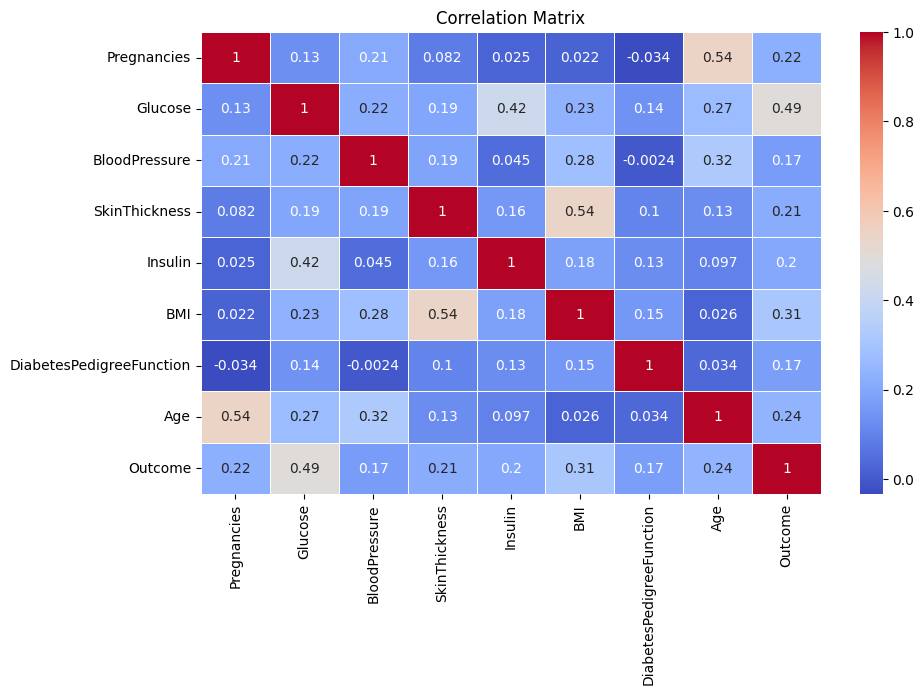

In [ ]:
# 2. Correlation heatmap to understand relationships between features
plt.figure(figsize=(10, 6))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

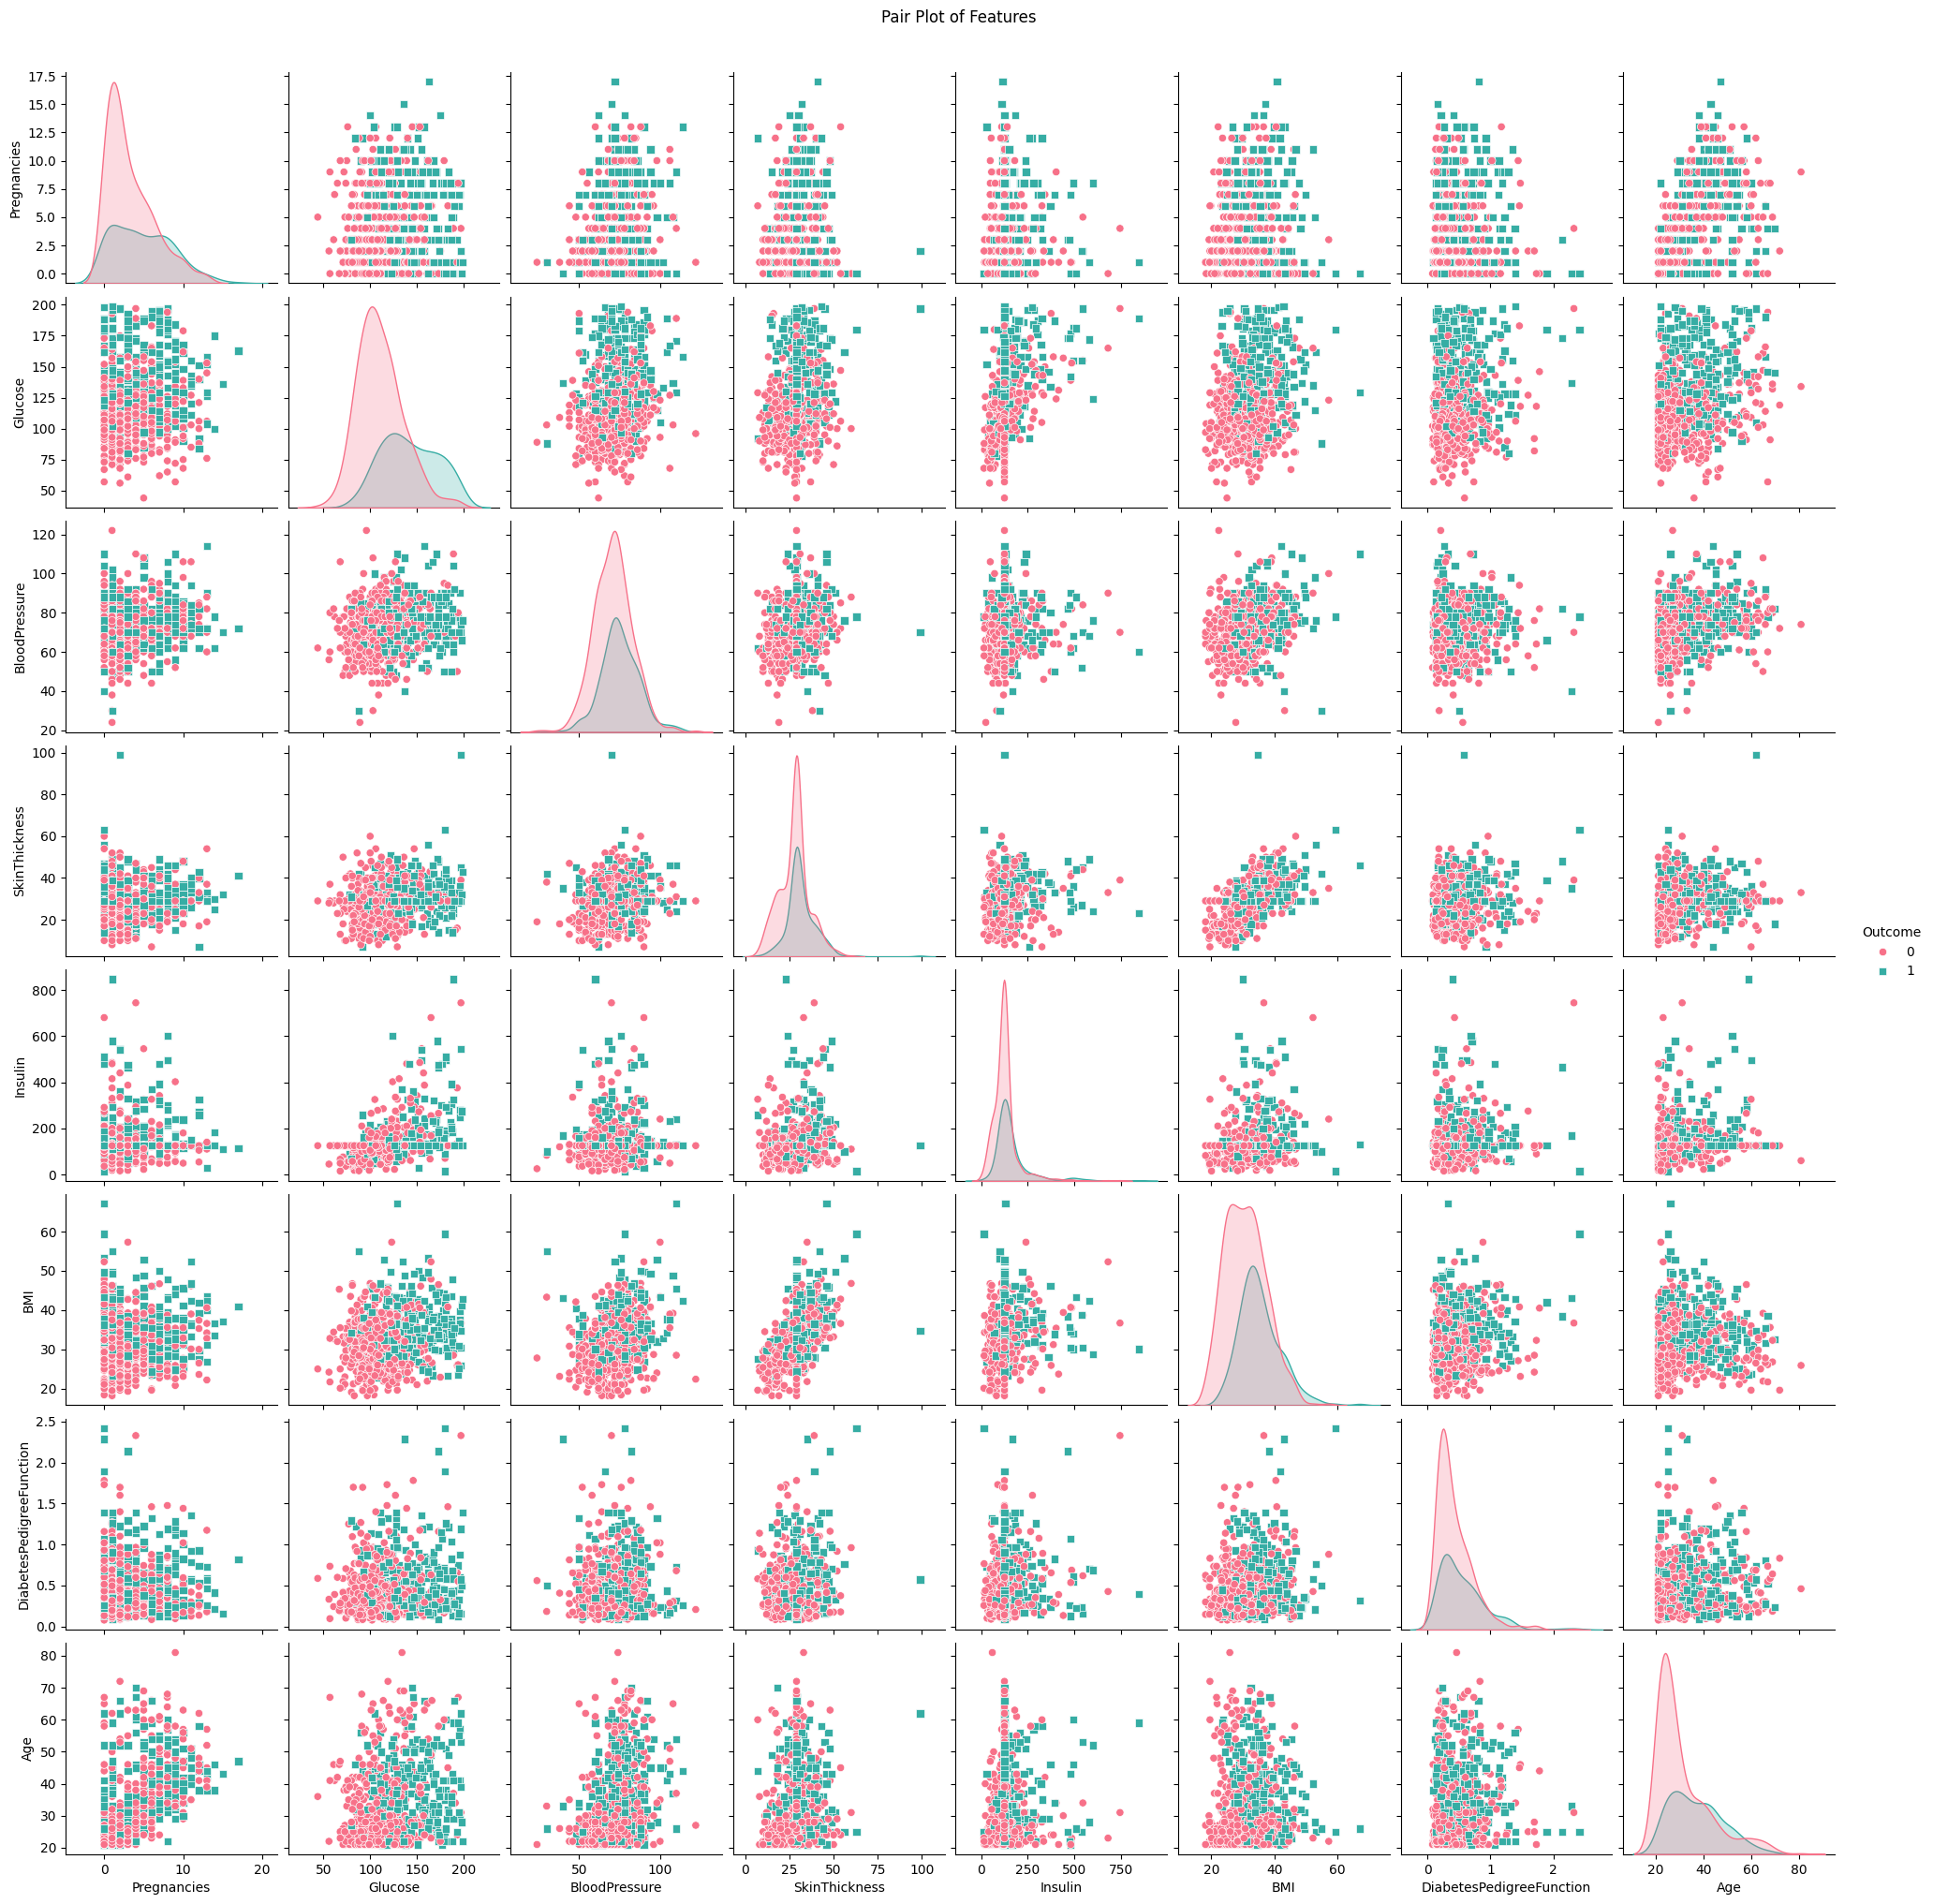

In [ ]:
# 3. Pair plot to visualize relationships and distributions
sns.pairplot(data, hue='Outcome', markers=["o", "s"], palette="husl")
plt.suptitle('Pair Plot of Features', y=1.02)
plt.show()

**Data Preprocessing**

Data preprocessing is a fundamental step in preparing the Pima Indians Diabetes dataset for machine learning. It begins with **scaling the features** using **StandardScaler**, which standardizes the dataset by transforming the features to have a mean of zero and a standard deviation of one. This ensures that all features are on the same scale, preventing any one feature from disproportionately influencing the model. Next, the data is split into **training** and **testing** sets, allowing us to train the model on one subset and evaluate its performance on another, unseen subset. This helps assess the model's ability to generalize to new data. Proper preprocessing is essential for building accurate and reliable machine learning models.

In [5]:
# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print the shapes of the datasets
print(f"\nTraining features shape: {X_train_scaled.shape}")
print(f"Test features shape: {X_test_scaled.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")


Training features shape: (537, 8)
Test features shape: (231, 8)
Training labels shape: (537,)
Test labels shape: (231,)


In [6]:
# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Feature  Selection using Random forest**

Feature selection with Random Forest is a powerful method for identifying the most relevant features in a dataset. Random Forest inherently performs feature importance ranking by evaluating how much each feature contributes to reducing the impurity (such as Gini Impurity or Entropy) across all the decision trees in the forest.

To perform feature selection with Random Forest:

Train a Random Forest model: We first train a Random Forest model on the dataset.

Extract feature importances: After training, the model provides a score for each feature based on its contribution to the model’s predictive performance.

Rank features: Features are ranked by their importance score, and less important features can be removed.

Retain top features: Select the top N most important features to train the model again, potentially improving its performance by reducing overfitting and improving interpretability.

<ipython-input-7-eeb5fb1d67cc>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")


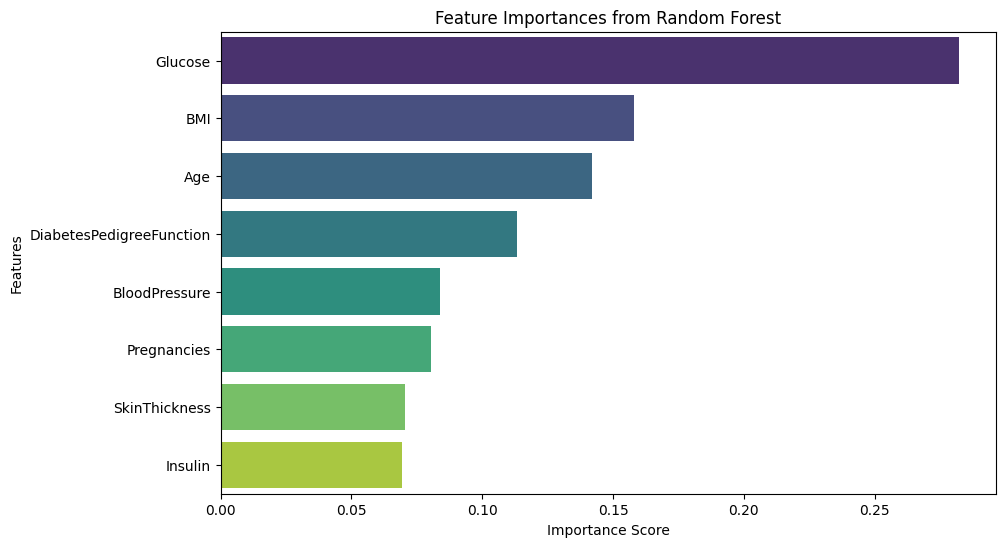

Top 3 features: ['Glucose' 'BMI' 'Age']


In [7]:
# Feature Selection with Random Forest

from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifier
def train_random_forest(X_train, y_train):
    # Create a RandomForestClassifier model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model on the training data
    rf_model.fit(X_train, y_train)

    return rf_model

# Plot feature importances
def plot_feature_importances(importances, feature_names):
    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # Sort the DataFrame by importance values in descending order
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
    plt.title('Feature Importances from Random Forest')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

    return feature_importances

# Call the function to train the Random Forest model
rf_model = train_random_forest(X_train_scaled, y_train)

# Get the feature importances from the trained model
importances = rf_model.feature_importances_

# Plot the feature importances
feature_importances_df = plot_feature_importances(importances, X.columns)

# Display top N features (e.g., top 3)
top_n_features = feature_importances_df['Feature'][:3].values
print(f"Top {len(top_n_features)} features: {top_n_features}")


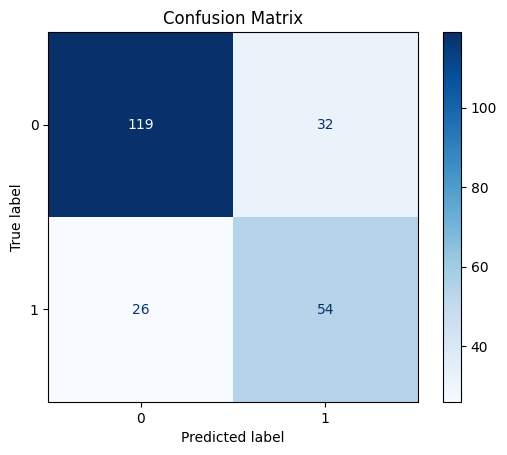

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Train Random Forest Classifier and get feature importances
def train_random_forest(X_train, y_train):
    # Initialize RandomForestClassifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    # Fit model to training data
    rf_model.fit(X_train, y_train)
    return rf_model

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Select top N important features
def select_top_n_features(X_train, feature_importances, top_n=5):
    # Get indices of the top N features based on importance
    top_n_indices = np.argsort(feature_importances)[::-1][:top_n]
    # Select top N features from the training data
    X_train_selected = X_train.iloc[:, top_n_indices]
    return X_train_selected, top_n_indices


# Step 1: Train Random Forest on all features
rf_model = train_random_forest(X_train, y_train)

# Step 2: Get the feature importances
importances = rf_model.feature_importances_

# Step 3: Select top N important features (e.g., top 5)
top_n_features = 5
X_train_selected, top_n_indices = select_top_n_features(X_train, importances, top_n=top_n_features)

# Step 4: Train a new model using only the selected features
rf_model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_selected.fit(X_train_selected, y_train)

# Step 5: Evaluate the model using confusion matrix
X_test_selected = X_test.iloc[:, top_n_indices]
y_pred = rf_model_selected.predict(X_test_selected)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y_test))


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Step 1: Train a Random Forest model to identify important features
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Step 2: Get feature importances from the trained model
feature_importances = rf.feature_importances_

# Step 3: Select features above a certain importance threshold

threshold = np.mean(feature_importances)
selected_features = np.where(feature_importances > threshold)[0]

# Step 4: Filter the train and test sets to include only the selected features
X_train_selected_rf = X_train_scaled[:, selected_features]
X_test_selected_rf = X_test_scaled[:, selected_features]

# Step 5: Train a Random Forest model using only the selected features
rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected_rf, y_train)

# Step 6: Predict and evaluate accuracy on the test set
y_pred_rf_selected = rf_selected.predict(X_test_selected_rf)
accuracy_rf_selected = accuracy_score(y_test, y_pred_rf_selected)

print(f"Test Accuracy with Selected Features (Random Forest): {accuracy_rf_selected:.4f}")


Test Accuracy with Selected Features (Random Forest): 0.6970


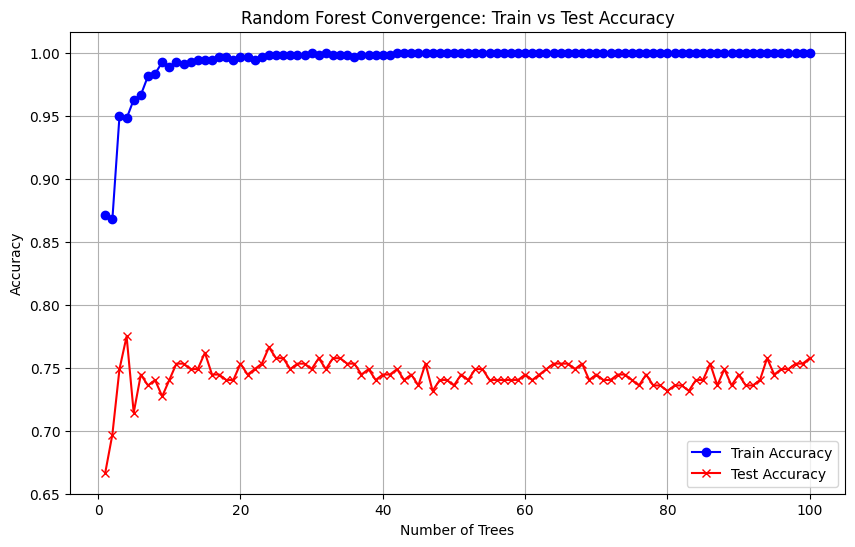

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifier and track performance over trees
def train_random_forest_with_convergence(X_train, y_train, X_test, y_test, n_trees=100):
    # List to store training and test accuracies
    train_accuracies = []
    test_accuracies = []

    # Initialize RandomForestClassifier
    rf_model = RandomForestClassifier(n_estimators=1, random_state=42)

    # Incrementally add trees
    for n in range(1, n_trees + 1):
        # Fit the model with n trees
        rf_model.set_params(n_estimators=n)
        rf_model.fit(X_train, y_train)

        # Predict on train and test sets
        train_pred = rf_model.predict(X_train)
        test_pred = rf_model.predict(X_test)

        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, train_pred)
        test_accuracy = accuracy_score(y_test, test_pred)

        # Store the accuracies
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    return train_accuracies, test_accuracies

# Call the function to track convergence
train_accuracies, test_accuracies = train_random_forest_with_convergence(X_train_scaled, y_train, X_test_scaled, y_test, n_trees=100)

# Plot the convergence graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_accuracies, label='Train Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(range(1, 101), test_accuracies, label='Test Accuracy', color='red', linestyle='-', marker='x')

plt.title('Random Forest Convergence: Train vs Test Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model and calculate metrics
def calculate_metrics(y_true, y_pred):
    # Calculate Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate Precision
    precision = precision_score(y_true, y_pred, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class

    # Calculate Recall
    recall = recall_score(y_true, y_pred, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class

    # Calculate F1 Score
    f1 = f1_score(y_true, y_pred, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class

    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

# Example usage:
# Assuming y_test is the true labels and y_pred is the predicted labels from your model
# y_pred = rf_model_selected.predict(X_test_selected)

# Call the function with true labels and predicted labels
calculate_metrics(y_test, y_pred)


Accuracy: 0.7489
Precision: 0.6279
Recall: 0.6750
F1 Score: 0.6506


(0.7489177489177489, 0.627906976744186, 0.675, 0.6506024096385542)

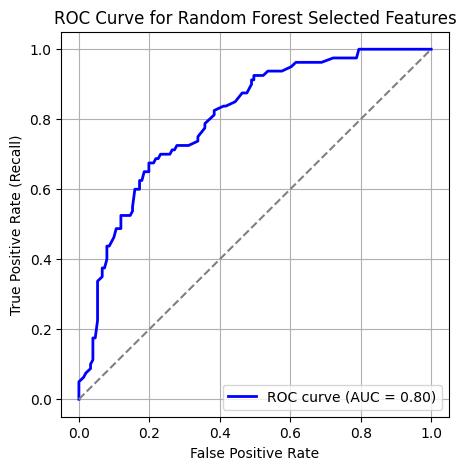

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

    # Compute AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve for Random Forest Selected Features')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



# Get the predicted probabilities (for binary classification, use the probability of the positive class)
y_pred_prob = rf_model_selected.predict_proba(X_test_selected)[:, 1]  # For binary classification, take the 2nd column

# Call the function with true labels and predicted probabilities
plot_roc_curve(y_test, y_pred_prob)



**Feature Selection using XGBoost**

Feature selection with **XGBoost** is an effective method for identifying the most important features in a dataset. XGBoost inherently ranks features based on their contribution to reducing the loss function, such as **log-loss** for classification tasks, across the decision trees in the boosting process. After training the model, we can extract feature importance using metrics like **gain** (the average contribution of a feature to improving model performance), **cover** (the frequency a feature is used in splits), and **frequency** (the number of times a feature is used in decision trees). By ranking the features based on these importance scores, we can select the most relevant ones, discarding the less important features. This helps reduce the dimensionality of the dataset, improve model efficiency, and prevent overfitting. XGBoost’s ability to handle non-linear relationships, missing values, and multicollinearity makes it particularly useful for feature selection in complex datasets. Overall, feature selection with **XGBoost** enables us to build a more robust, efficient, and interpretable model.

<ipython-input-15-3f3fab00efa2>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")


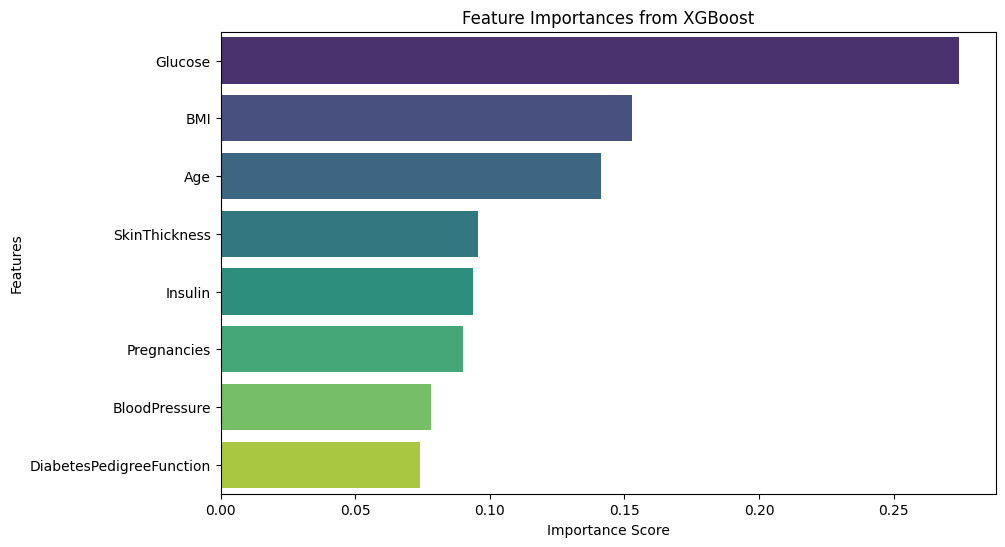

Top 3 features: ['Glucose' 'BMI' 'Age']


In [15]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Train XGBoost Classifier
def train_xgboost(X_train, y_train):
    # Create an XGBoost model
    xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)

    # Train the model on the training data
    xgb_model.fit(X_train, y_train)

    return xgb_model

# Plot feature importances
def plot_feature_importances(importances, feature_names):
    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # Sort the DataFrame by importance values in descending order
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
    plt.title('Feature Importances from XGBoost')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

    return feature_importances

# Call the function to train the XGBoost model
xgb_model = train_xgboost(X_train_scaled, y_train)

# Get the feature importances from the trained model
importances = xgb_model.feature_importances_

# Plot the feature importances
feature_importances_df = plot_feature_importances(importances, X.columns)

# Display top N features (e.g., top 3)
top_n_features = feature_importances_df['Feature'][:3].values
print(f"Top {len(top_n_features)} features: {top_n_features}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:38:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


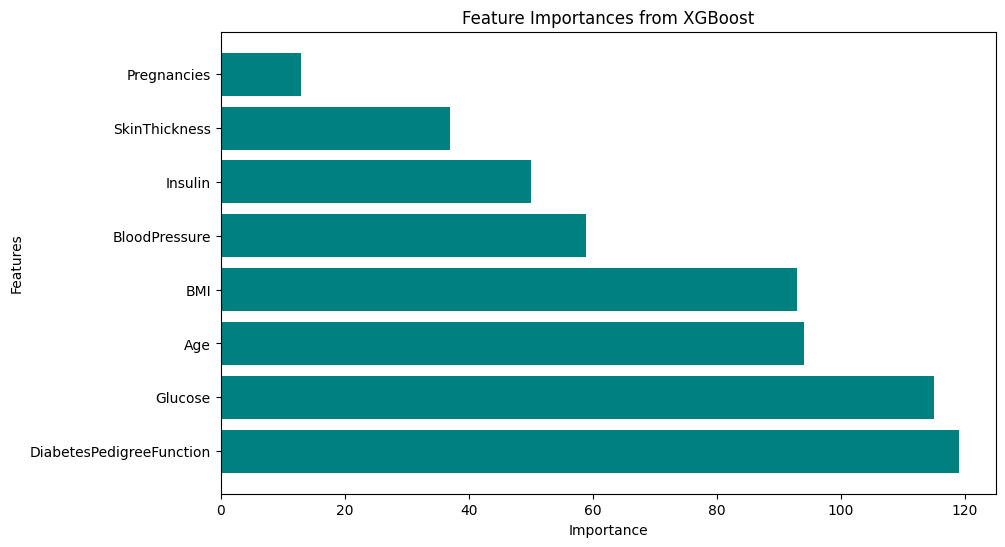

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:38:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6710
Precision: 0.5476
Recall: 0.2875
F1 Score: 0.3770


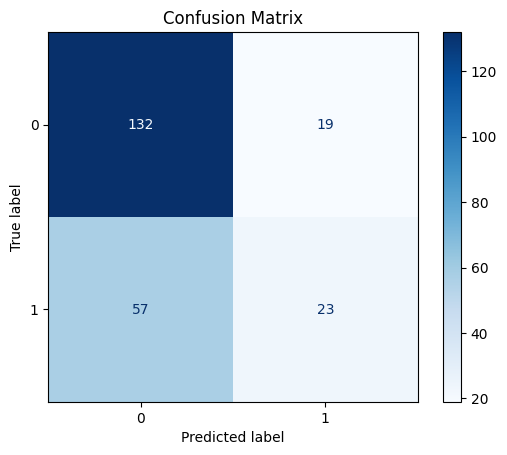

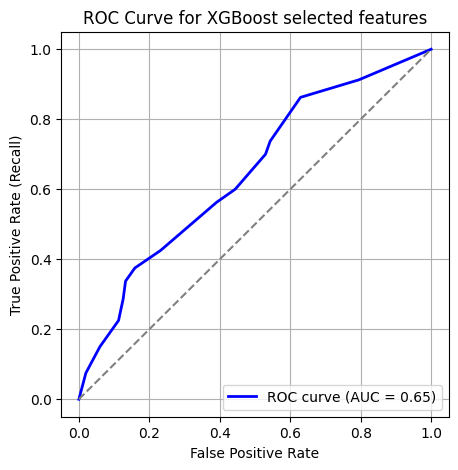

In [18]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Train XGBoost model
def train_xgboost(X_train, y_train, n_estimators=100, max_depth=3, learning_rate=0.1):
    # Convert data to DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)

    # Set XGBoost parameters
    params = {
        'objective': 'binary:logistic',  # Assuming binary classification
        'eval_metric': 'logloss',
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'n_estimators': n_estimators,
    }

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_boost_round=n_estimators)

    return model

# Feature importance function (based on trained XGBoost model)
def plot_feature_importances(model, feature_names):
    importances = model.get_fscore()
    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': [importances.get(f, 0) for f in feature_names]
    })

    # Sort features by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='teal')
    plt.title('Feature Importances from XGBoost')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

    return feature_importances

# Confusion matrix function
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate model using various metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')  # Use 'micro', 'macro', or 'weighted' for multi-class
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

# Plot ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve for XGBoost selected features')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Feature selection based on feature importance
def select_top_n_features(X_train, importances, top_n=5):
    top_n_indices = np.argsort(importances)[::-1][:top_n]
    X_train_selected = X_train.iloc[:, top_n_indices]
    return X_train_selected, top_n_indices

# Example usage:

# Example dataset (replace with your actual data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model on the full dataset
model = train_xgboost(X_train, y_train, n_estimators=100, max_depth=3, learning_rate=0.1)

# Step 1: Plot feature importances
importances = model.get_fscore()  # Get feature importances
feature_importances_df = plot_feature_importances(model, X_train.columns)

# Step 2: Select top N important features
top_n_features = 5  # You can adjust this number
X_train_selected, top_n_indices = select_top_n_features(X_train, importances, top_n=top_n_features)

# Step 3: Train XGBoost model using only selected features
model_selected = train_xgboost(X_train_selected, y_train)

# Step 4: Evaluate the model
X_test_selected = X_test.iloc[:, top_n_indices]
y_pred_prob = model_selected.predict(xgb.DMatrix(X_test_selected))  # Get predicted probabilities

# Convert probabilities to binary class labels (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
calculate_metrics(y_test, y_pred)

# Step 5: Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.unique(y_test))

# Step 6: Plot ROC curve
plot_roc_curve(y_test, y_pred_prob)


**Using PSO for feature selection using random forest**

In this notebook, we apply **Particle Swarm Optimization (PSO)** for **feature selection** to improve the performance of a **Random Forest** model on the **Pima Indians Diabetes dataset**. PSO is used to search for the most relevant features by evaluating the performance of different feature subsets based on the accuracy of the Random Forest classifier. The PSO algorithm iteratively updates particles representing different feature combinations to maximize the classification performance. Once PSO selects the optimal subset of features, we train a Random Forest model on this reduced feature set and evaluate its performance. The goal is to improve the model's efficiency by reducing dimensionality while maintaining or enhancing predictive accuracy. This approach helps in selecting the most important features for predicting diabetes, ultimately improving model interpretability and reducing overfitting.

Best Parameters: n_estimators=89, max_depth=11, min_samples_split=7
Accuracy: 0.7792
Precision: 0.6790
Recall: 0.6875
F1 Score: 0.6832


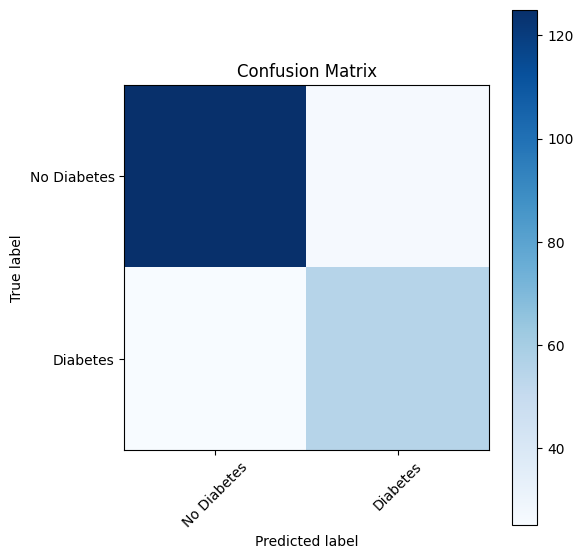

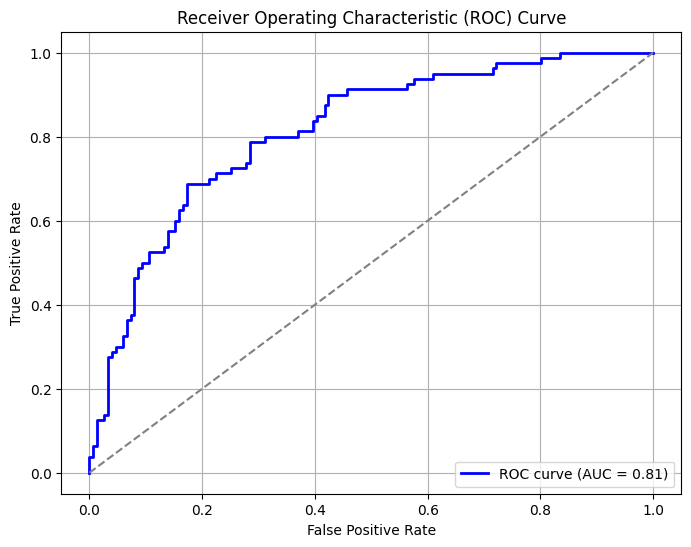

In [19]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=columns)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Particle Swarm Optimization (PSO) implementation
class Particle:
    def __init__(self, dimensions, lower_bounds, upper_bounds):
        self.position = np.array([random.uniform(lower_bounds[i], upper_bounds[i]) for i in range(dimensions)])
        self.velocity = np.random.uniform(-1, 1, size=dimensions)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

class PSO:
    def __init__(self, objective_function, dimensions, lower_bounds, upper_bounds, num_particles=30, max_iter=100, w=0.5, c1=1.5, c2=1.5):
        self.objective_function = objective_function
        self.dimensions = dimensions
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2

        # Initialize particles
        self.particles = [Particle(dimensions, lower_bounds, upper_bounds) for _ in range(num_particles)]
        self.global_best_position = np.copy(self.particles[0].best_position)
        self.global_best_score = float('inf')

    def optimize(self):
        for iteration in range(self.max_iter):
            for particle in self.particles:
                # Evaluate the objective function for the particle
                score = self.objective_function(particle.position)

                # Update personal best
                if score < particle.best_score:
                    particle.best_score = score
                    particle.best_position = np.copy(particle.position)

                # Update global best
                if score < self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = np.copy(particle.position)

            # Update the velocity and position of each particle
            for particle in self.particles:
                inertia = self.w * particle.velocity
                cognitive = self.c1 * random.random() * (particle.best_position - particle.position)
                social = self.c2 * random.random() * (self.global_best_position - particle.position)
                particle.velocity = inertia + cognitive + social
                particle.position = np.clip(particle.position + particle.velocity, self.lower_bounds, self.upper_bounds)

        return self.global_best_position, self.global_best_score

# Objective function: Evaluate Random Forest model performance
def objective_function(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    min_samples_split = int(params[2])

    # Train and evaluate a Random Forest model with the given hyperparameters
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Return negative accuracy to minimize the objective function
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Minimize the negative accuracy

# Define the hyperparameter search space (for Random Forest)
lower_bounds = [10, 1, 2]  # n_estimators, max_depth, min_samples_split
upper_bounds = [200, 20, 10]  # n_estimators, max_depth, min_samples_split

# Initialize PSO and optimize
pso = PSO(objective_function, dimensions=3, lower_bounds=lower_bounds, upper_bounds=upper_bounds, num_particles=30, max_iter=50)
best_params, best_score = pso.optimize()

# Convert best parameters to integers
n_estimators_best = int(best_params[0])
max_depth_best = int(best_params[1])
min_samples_split_best = int(best_params[2])

# Train a Random Forest with the best found hyperparameters
rf_best = RandomForestClassifier(n_estimators=n_estimators_best, max_depth=max_depth_best, min_samples_split=min_samples_split_best, random_state=42)
rf_best.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Print the evaluation metrics
print(f"Best Parameters: n_estimators={n_estimators_best}, max_depth={max_depth_best}, min_samples_split={min_samples_split_best}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['No Diabetes', 'Diabetes'], rotation=45)
plt.yticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# ROC Curve
y_pred_prob = rf_best.predict_proba(X_test)[:, 1]  # For binary classification, select the probability of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**PSO for Feature selection using XGBoost**

In this notebook, we implement **Particle Swarm Optimization (PSO)** for **feature selection** to enhance the performance of an **XGBoost** model on the **Pima Indians Diabetes dataset**. PSO is an optimization technique used to search the feature space and identify the most relevant features for prediction. By using PSO, we iteratively evaluate subsets of features based on the performance of the **XGBoost** model, which is a gradient boosting algorithm known for its high predictive power. Each particle in the PSO swarm represents a subset of features, and the fitness function evaluates the performance of **XGBoost** using metrics like **accuracy** or **F1 score**. The particles update their positions to explore better feature combinations, aiming to find the optimal subset that maximizes model performance. Once the best feature subset is selected, we train the **XGBoost** model with these features and evaluate its accuracy. This approach not only reduces the dimensionality of the dataset but also improves the model’s efficiency, reduces overfitting, and enhances predictive accuracy for diabetes prediction.

Best Parameters: max_depth=8, learning_rate=0.1009, n_estimators=133, gamma=2.9723898411860588
Accuracy: 0.7922
Precision: 0.7051
Recall: 0.6875
F1 Score: 0.6962


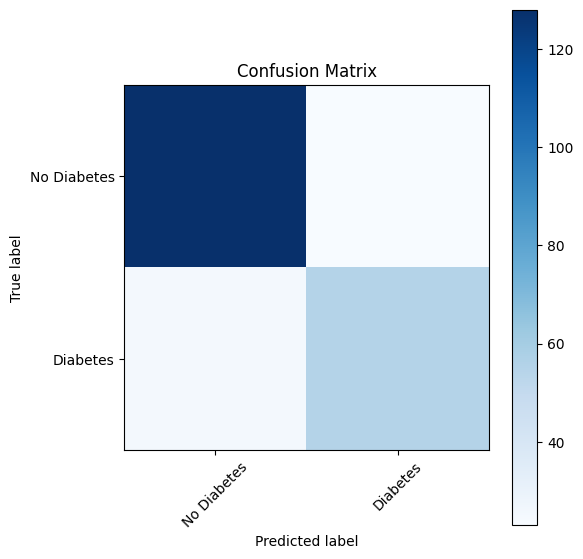

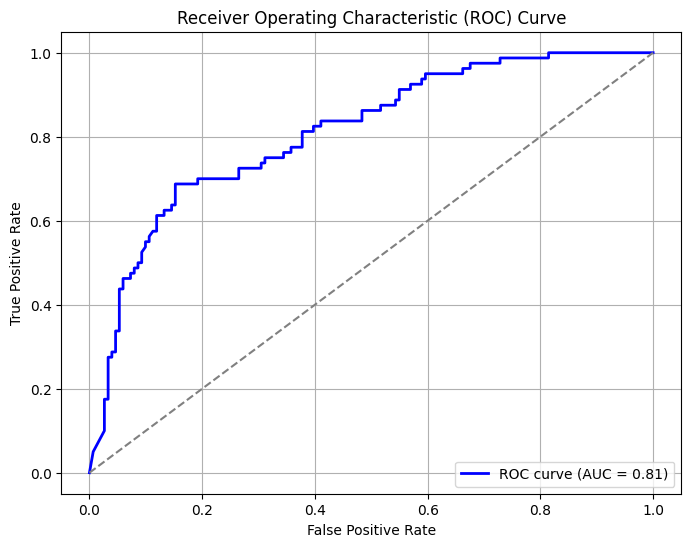

In [40]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=columns)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Particle Swarm Optimization (PSO) implementation
class Particle:
    def __init__(self, dimensions, lower_bounds, upper_bounds):
        self.position = np.array([random.uniform(lower_bounds[i], upper_bounds[i]) for i in range(dimensions)])
        self.velocity = np.random.uniform(-1, 1, size=dimensions)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

class PSO:
    def __init__(self, objective_function, dimensions, lower_bounds, upper_bounds, num_particles=30, max_iter=100, w=0.5, c1=1.5, c2=1.5):
        self.objective_function = objective_function
        self.dimensions = dimensions
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2

        # Initialize particles
        self.particles = [Particle(dimensions, lower_bounds, upper_bounds) for _ in range(num_particles)]
        self.global_best_position = np.copy(self.particles[0].best_position)
        self.global_best_score = float('inf')

    def optimize(self):
        for iteration in range(self.max_iter):
            for particle in self.particles:
                # Evaluate the objective function for the particle
                score = self.objective_function(particle.position)

                # Update personal best
                if score < particle.best_score:
                    particle.best_score = score
                    particle.best_position = np.copy(particle.position)

                # Update global best
                if score < self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = np.copy(particle.position)

            # Update the velocity and position of each particle
            for particle in self.particles:
                inertia = self.w * particle.velocity
                cognitive = self.c1 * random.random() * (particle.best_position - particle.position)
                social = self.c2 * random.random() * (self.global_best_position - particle.position)
                particle.velocity = inertia + cognitive + social
                particle.position = np.clip(particle.position + particle.velocity, self.lower_bounds, self.upper_bounds)

        return self.global_best_position, self.global_best_score

# Objective function: Evaluate XGBoost model performance
def objective_function(params):
    max_depth = int(params[0])
    learning_rate = params[1]
    n_estimators = int(params[2])
    gamma = params[3]

    # Train and evaluate an XGBoost model with the given hyperparameters
    model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Return negative accuracy to minimize the objective function
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Minimize the negative accuracy

# Define the hyperparameter search space (for XGBoost)
lower_bounds = [3, 0.01, 50, 0]  # max_depth, learning_rate, n_estimators, gamma
upper_bounds = [10, 0.3, 200, 5]  # max_depth, learning_rate, n_estimators, gamma

# Initialize PSO and optimize
pso = PSO(objective_function, dimensions=4, lower_bounds=lower_bounds, upper_bounds=upper_bounds, num_particles=30, max_iter=50)
best_params, best_score = pso.optimize()

# Convert best parameters to integers
max_depth_best = int(best_params[0])
learning_rate_best = best_params[1]
n_estimators_best = int(best_params[2])
gamma_best = best_params[3]

# Train an XGBoost model with the best found hyperparameters
xgb_best = xgb.XGBClassifier(max_depth=max_depth_best, learning_rate=learning_rate_best, n_estimators=n_estimators_best, gamma=gamma_best, random_state=42)
xgb_best.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = xgb_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Print the evaluation metrics
print(f"Best Parameters: max_depth={max_depth_best}, learning_rate={learning_rate_best:.4f}, n_estimators={n_estimators_best}, gamma={gamma_best}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['No Diabetes', 'Diabetes'], rotation=45)
plt.yticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# ROC Curve
y_pred_prob = xgb_best.predict_proba(X_test)[:, 1]  # For binary classification, select the probability of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**IPSO with Random Forest**

We implement **Improved Particle Swarm Optimization (IPSO)**, which is a hybrid approach combining **Particle Swarm Optimization (PSO)** with a **Genetic Algorithm (GA)**, for **feature selection** to enhance the performance of a **Random Forest (RF)** model on the **Pima Indians Diabetes dataset**. IPSO is designed to address some of the limitations of traditional PSO by incorporating the **Genetic Algorithm**'s crossover and mutation operations, which help avoid premature convergence and improve the exploration of the feature space.

In this approach, **PSO** is used for global search, while the **Genetic Algorithm** helps refine the solution by promoting diversity in the swarm and improving convergence to the optimal feature set. The fitness of each particle, representing a subset of features, is evaluated based on the performance of the **Random Forest** model. The IPSO algorithm iteratively updates the particles and evolves the feature subset through crossover and mutation, ultimately selecting the most relevant features for predicting diabetes.

By using **IPSO with Random Forest**, we can effectively reduce the dimensionality of the dataset, avoid overfitting, and improve the model's performance. This hybrid method allows for a more robust feature selection process by combining the strengths of both PSO and GA, ultimately leading to better predictive accuracy and model efficiency for the diabetes prediction task.

Best Parameters: n_estimators=89, max_depth=11, min_samples_split=7
Accuracy: 0.7792
Precision: 0.6790
Recall: 0.6875
F1 Score: 0.6832


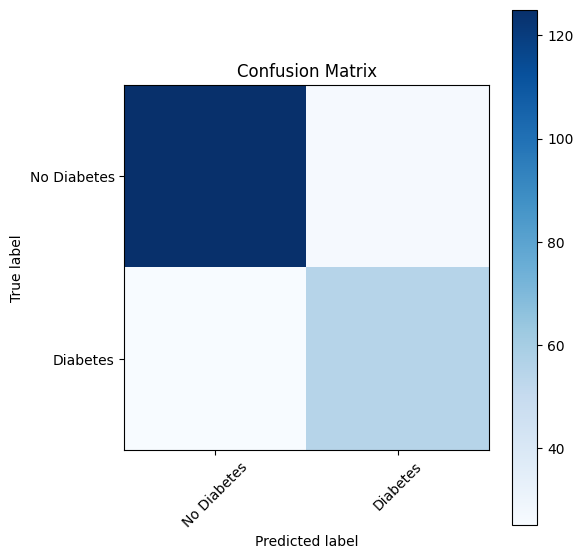

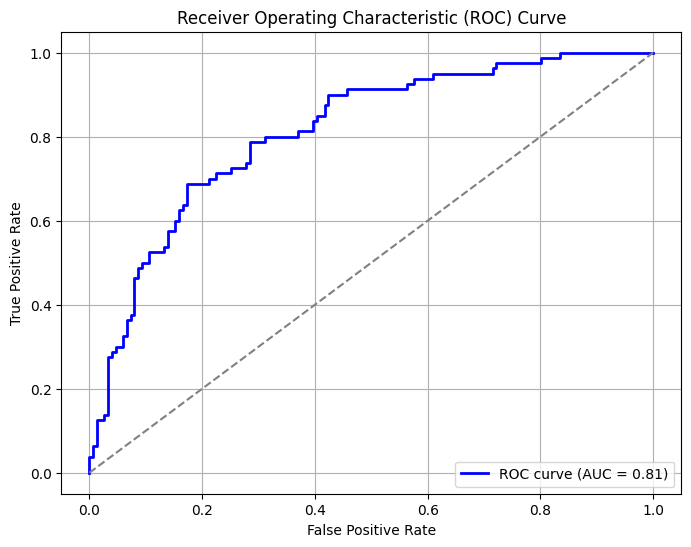

In [41]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=columns)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Particle class for IPSO
class Particle:
    def __init__(self, dimensions, lower_bounds, upper_bounds):
        self.position = np.array([random.uniform(lower_bounds[i], upper_bounds[i]) for i in range(dimensions)])
        self.velocity = np.random.uniform(-1, 1, size=dimensions)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

# IPSO Algorithm combining PSO and GA
class IPSO:
    def __init__(self, objective_function, dimensions, lower_bounds, upper_bounds, num_particles=30, max_iter=100, w=0.5, c1=1.5, c2=1.5, crossover_prob=0.9, mutation_prob=0.1):
        self.objective_function = objective_function
        self.dimensions = dimensions
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob

        # Initialize particles
        self.particles = [Particle(dimensions, lower_bounds, upper_bounds) for _ in range(num_particles)]
        self.global_best_position = np.copy(self.particles[0].best_position)
        self.global_best_score = float('inf')

    def optimize(self):
        for iteration in range(self.max_iter):
            for particle in self.particles:
                # Evaluate the objective function for the particle
                score = self.objective_function(particle.position)

                # Update personal best
                if score < particle.best_score:
                    particle.best_score = score
                    particle.best_position = np.copy(particle.position)

                # Update global best
                if score < self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = np.copy(particle.position)

            # Update the velocity and position of each particle using PSO
            for particle in self.particles:
                inertia = self.w * particle.velocity
                cognitive = self.c1 * random.random() * (particle.best_position - particle.position)
                social = self.c2 * random.random() * (self.global_best_position - particle.position)
                particle.velocity = inertia + cognitive + social
                particle.position = np.clip(particle.position + particle.velocity, self.lower_bounds, self.upper_bounds)

            # Perform crossover and mutation (GA steps)
            self.generation_crossover_mutation()

        return self.global_best_position, self.global_best_score

    def generation_crossover_mutation(self):
        # Crossover and Mutation - GA part
        for i in range(self.num_particles):
            if random.random() < self.crossover_prob:
                parent1, parent2 = random.sample(self.particles, 2)
                crossover_point = random.randint(1, self.dimensions-1)
                # Crossover
                child_position = np.concatenate([parent1.position[:crossover_point], parent2.position[crossover_point:]])
                child_position = np.clip(child_position, self.lower_bounds, self.upper_bounds)
                child_score = self.objective_function(child_position)

                # Replace worst particle if better
                if child_score < parent1.best_score:
                    parent1.position = child_position
                    parent1.best_position = child_position
                    parent1.best_score = child_score

            # Mutation
            if random.random() < self.mutation_prob:
                mutation_index = random.randint(0, self.dimensions-1)
                mutation_value = random.uniform(self.lower_bounds[mutation_index], self.upper_bounds[mutation_index])
                self.particles[i].position[mutation_index] = mutation_value
                self.particles[i].position = np.clip(self.particles[i].position, self.lower_bounds, self.upper_bounds)
                self.particles[i].best_position = np.copy(self.particles[i].position)
                self.particles[i].best_score = self.objective_function(self.particles[i].position)

# Objective function: Evaluate Random Forest model performance
def objective_function(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    min_samples_split = int(params[2])

    # Train and evaluate a Random Forest model with the given hyperparameters
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Return negative accuracy to minimize the objective function
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Minimize the negative accuracy

# Define the hyperparameter search space (for Random Forest)
lower_bounds = [10, 1, 2]  # n_estimators, max_depth, min_samples_split
upper_bounds = [200, 20, 10]  # n_estimators, max_depth, min_samples_split

# Initialize IPSO and optimize
ipso = IPSO(objective_function, dimensions=3, lower_bounds=lower_bounds, upper_bounds=upper_bounds, num_particles=30, max_iter=50)
best_params, best_score = ipso.optimize()

# Convert best parameters to integers
n_estimators_best = int(best_params[0])
max_depth_best = int(best_params[1])
min_samples_split_best = int(best_params[2])

# Train a Random Forest with the best found hyperparameters
rf_best = RandomForestClassifier(n_estimators=n_estimators_best, max_depth=max_depth_best, min_samples_split=min_samples_split_best, random_state=42)
rf_best.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Print the evaluation metrics
print(f"Best Parameters: n_estimators={n_estimators_best}, max_depth={max_depth_best}, min_samples_split={min_samples_split_best}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['No Diabetes', 'Diabetes'], rotation=45)
plt.yticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# ROC Curve
y_pred_prob = rf_best.predict_proba(X_test)[:, 1]  # For binary classification, select the probability of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**IPSO with XGBoost**

Best Parameters: max_depth=7, learning_rate=0.0995, n_estimators=139, gamma=3.0012745539429733
Accuracy: 0.7879
Precision: 0.6962
Recall: 0.6875
F1 Score: 0.6918


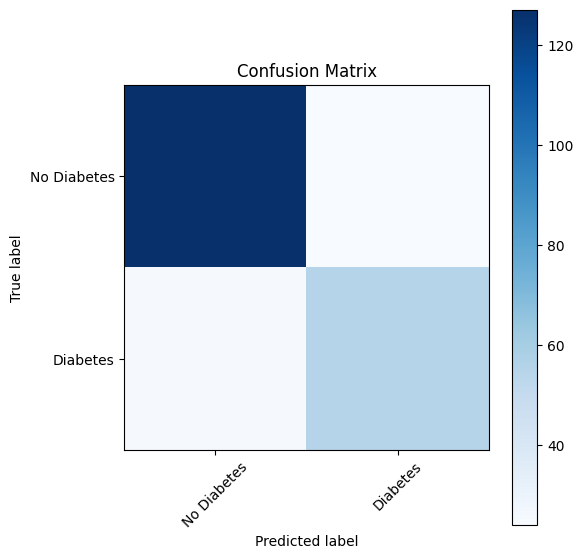

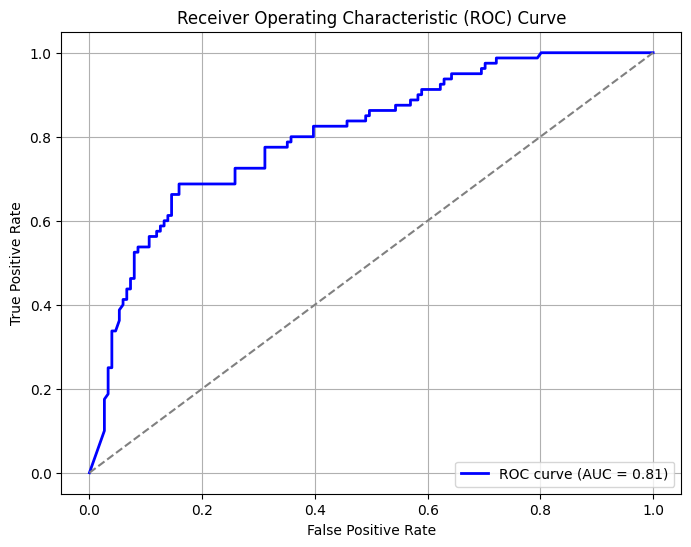

In [42]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=columns)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Particle class for IPSO
class Particle:
    def __init__(self, dimensions, lower_bounds, upper_bounds):
        self.position = np.array([random.uniform(lower_bounds[i], upper_bounds[i]) for i in range(dimensions)])
        self.velocity = np.random.uniform(-1, 1, size=dimensions)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

# IPSO Algorithm combining PSO and GA
class IPSO:
    def __init__(self, objective_function, dimensions, lower_bounds, upper_bounds, num_particles=30, max_iter=100, w=0.5, c1=1.5, c2=1.5, crossover_prob=0.9, mutation_prob=0.1):
        self.objective_function = objective_function
        self.dimensions = dimensions
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob

        # Initialize particles
        self.particles = [Particle(dimensions, lower_bounds, upper_bounds) for _ in range(num_particles)]
        self.global_best_position = np.copy(self.particles[0].best_position)
        self.global_best_score = float('inf')

    def optimize(self):
        for iteration in range(self.max_iter):
            for particle in self.particles:
                # Evaluate the objective function for the particle
                score = self.objective_function(particle.position)

                # Update personal best
                if score < particle.best_score:
                    particle.best_score = score
                    particle.best_position = np.copy(particle.position)

                # Update global best
                if score < self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = np.copy(particle.position)

            # Update the velocity and position of each particle using PSO
            for particle in self.particles:
                inertia = self.w * particle.velocity
                cognitive = self.c1 * random.random() * (particle.best_position - particle.position)
                social = self.c2 * random.random() * (self.global_best_position - particle.position)
                particle.velocity = inertia + cognitive + social
                particle.position = np.clip(particle.position + particle.velocity, self.lower_bounds, self.upper_bounds)

            # Perform crossover and mutation (GA steps)
            self.generation_crossover_mutation()

        return self.global_best_position, self.global_best_score

    def generation_crossover_mutation(self):
        # Crossover and Mutation - GA part
        for i in range(self.num_particles):
            if random.random() < self.crossover_prob:
                parent1, parent2 = random.sample(self.particles, 2)
                crossover_point = random.randint(1, self.dimensions-1)
                # Crossover
                child_position = np.concatenate([parent1.position[:crossover_point], parent2.position[crossover_point:]])
                child_position = np.clip(child_position, self.lower_bounds, self.upper_bounds)
                child_score = self.objective_function(child_position)

                # Replace worst particle if better
                if child_score < parent1.best_score:
                    parent1.position = child_position
                    parent1.best_position = child_position
                    parent1.best_score = child_score

            # Mutation
            if random.random() < self.mutation_prob:
                mutation_index = random.randint(0, self.dimensions-1)
                mutation_value = random.uniform(self.lower_bounds[mutation_index], self.upper_bounds[mutation_index])
                self.particles[i].position[mutation_index] = mutation_value
                self.particles[i].position = np.clip(self.particles[i].position, self.lower_bounds, self.upper_bounds)
                self.particles[i].best_position = np.copy(self.particles[i].position)
                self.particles[i].best_score = self.objective_function(self.particles[i].position)

# Objective function: Evaluate XGBoost model performance
def objective_function(params):
    max_depth = int(params[0])
    learning_rate = params[1]
    n_estimators = int(params[2])
    gamma = params[3]

    # Train and evaluate an XGBoost model with the given hyperparameters
    model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Return negative accuracy to minimize the objective function
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Minimize the negative accuracy

# Define the hyperparameter search space (for XGBoost)
lower_bounds = [3, 0.01, 50, 0]  # max_depth, learning_rate, n_estimators, gamma
upper_bounds = [10, 0.3, 200, 5]  # max_depth, learning_rate, n_estimators, gamma

# Initialize IPSO and optimize
ipso = IPSO(objective_function, dimensions=4, lower_bounds=lower_bounds, upper_bounds=upper_bounds, num_particles=30, max_iter=50)
best_params, best_score = ipso.optimize()

# Convert best parameters to integers
max_depth_best = int(best_params[0])
learning_rate_best = best_params[1]
n_estimators_best = int(best_params[2])
gamma_best = best_params[3]

# Train an XGBoost model with the best found hyperparameters
xgb_best = xgb.XGBClassifier(max_depth=max_depth_best, learning_rate=learning_rate_best, n_estimators=n_estimators_best, gamma=gamma_best, random_state=42)
xgb_best.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = xgb_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Print the evaluation metrics
print(f"Best Parameters: max_depth={max_depth_best}, learning_rate={learning_rate_best:.4f}, n_estimators={n_estimators_best}, gamma={gamma_best}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['No Diabetes', 'Diabetes'], rotation=45)
plt.yticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# ROC Curve
y_pred_prob = xgb_best.predict_proba(X_test)[:, 1]  # For binary classification, select the probability of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**PSO-LS with Random Forest**

In this notebook, we use **PSO-LS (Particle Swarm Optimization with Local Search)** for feature selection with a **Random Forest (RF)** model on the **Pima Indians Diabetes dataset**. PSO-LS combines the global search ability of **PSO** with the local refinement of search techniques, such as **hill climbing**, to optimize feature selection. Initially, PSO explores various feature subsets, and then the local search fine-tunes the best solutions found. This hybrid approach helps reduce dimensionality, improve model accuracy, and prevent overfitting by selecting the most relevant features for predicting diabetes.

Best Parameters: n_estimators=192, max_depth=10, min_samples_split=6
Accuracy: 0.7662
Precision: 0.6625
Recall: 0.6625
F1 Score: 0.6625


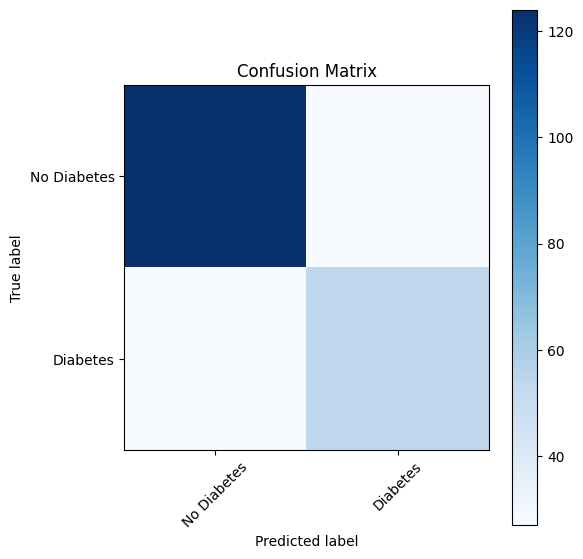

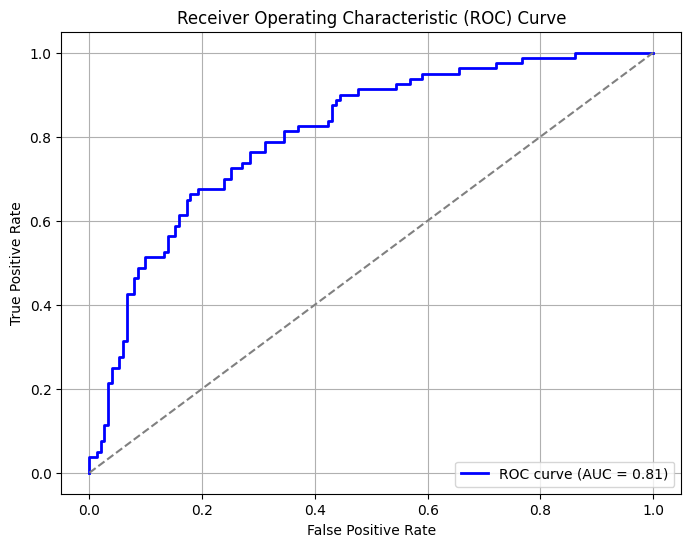

In [20]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=columns)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Particle class for PSO with Local Search on pBest
class Particle:
    def __init__(self, dimensions, lower_bounds, upper_bounds):
        self.position = np.array([random.uniform(lower_bounds[i], upper_bounds[i]) for i in range(dimensions)])
        self.velocity = np.random.uniform(-1, 1, size=dimensions)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

    def update_position(self, lower_bounds, upper_bounds):
        # Update position with local search around pBest
        step_size = 0.1  # The amount of search around pBest
        self.position = self.best_position + np.random.uniform(-step_size, step_size, size=len(self.position))
        self.position = np.clip(self.position, lower_bounds, upper_bounds)

# PSO with Local Search on pBest Algorithm
class PSO_LS:
    def __init__(self, objective_function, dimensions, lower_bounds, upper_bounds, num_particles=30, max_iter=100, w=0.5, c1=1.5, c2=1.5, local_search_prob=0.3):
        self.objective_function = objective_function
        self.dimensions = dimensions
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive coefficient
        self.c2 = c2  # Social coefficient
        self.local_search_prob = local_search_prob

        # Initialize particles
        self.particles = [Particle(dimensions, lower_bounds, upper_bounds) for _ in range(num_particles)]
        self.global_best_position = np.copy(self.particles[0].best_position)
        self.global_best_score = float('inf')

    def optimize(self):
        for iteration in range(self.max_iter):
            for particle in self.particles:
                # Evaluate the objective function for the particle
                score = self.objective_function(particle.position)

                # Update personal best (pBest)
                if score < particle.best_score:
                    particle.best_score = score
                    particle.best_position = np.copy(particle.position)

                # Update global best (gBest)
                if score < self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = np.copy(particle.position)

            # Update the velocity and position of each particle using PSO
            for particle in self.particles:
                inertia = self.w * particle.velocity
                cognitive = self.c1 * random.random() * (particle.best_position - particle.position)
                social = self.c2 * random.random() * (self.global_best_position - particle.position)
                particle.velocity = inertia + cognitive + social

                # Update position (with optional local search)
                particle.update_position(self.lower_bounds, self.upper_bounds)

                # Occasionally perform a local search around pBest
                if random.random() < self.local_search_prob:
                    particle.update_position(self.lower_bounds, self.upper_bounds)

        return self.global_best_position, self.global_best_score

# Objective function: Evaluate Random Forest model performance
def objective_function(params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    min_samples_split = int(params[2])

    # Train and evaluate a Random Forest model with the given hyperparameters
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Return negative accuracy to minimize the objective function
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Minimize the negative accuracy

# Define the hyperparameter search space (for Random Forest)
lower_bounds = [10, 1, 2]  # n_estimators, max_depth, min_samples_split
upper_bounds = [200, 20, 10]  # n_estimators, max_depth, min_samples_split

# Initialize PSO with Local Search and optimize
pso_ls = PSO_LS(objective_function, dimensions=3, lower_bounds=lower_bounds, upper_bounds=upper_bounds, num_particles=30, max_iter=50)
best_params, best_score = pso_ls.optimize()

# Convert best parameters to integers
n_estimators_best = int(best_params[0])
max_depth_best = int(best_params[1])
min_samples_split_best = int(best_params[2])

# Train a Random Forest with the best found hyperparameters
rf_best = RandomForestClassifier(n_estimators=n_estimators_best, max_depth=max_depth_best, min_samples_split=min_samples_split_best, random_state=42)
rf_best.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Print the evaluation metrics
print(f"Best Parameters: n_estimators={n_estimators_best}, max_depth={max_depth_best}, min_samples_split={min_samples_split_best}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['No Diabetes', 'Diabetes'], rotation=45)
plt.yticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# ROC Curve
y_pred_prob = rf_best.predict_proba(X_test)[:, 1]  # For binary classification, select the probability of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**PSO-LS with XGBoost**

Best Parameters: max_depth=9, learning_rate=0.1614, n_estimators=53, gamma=2.9968687327531875
Accuracy: 0.7879
Precision: 0.6962
Recall: 0.6875
F1 Score: 0.6918


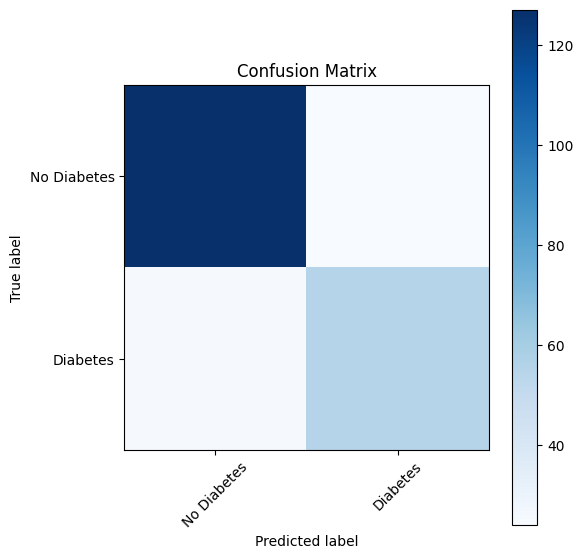

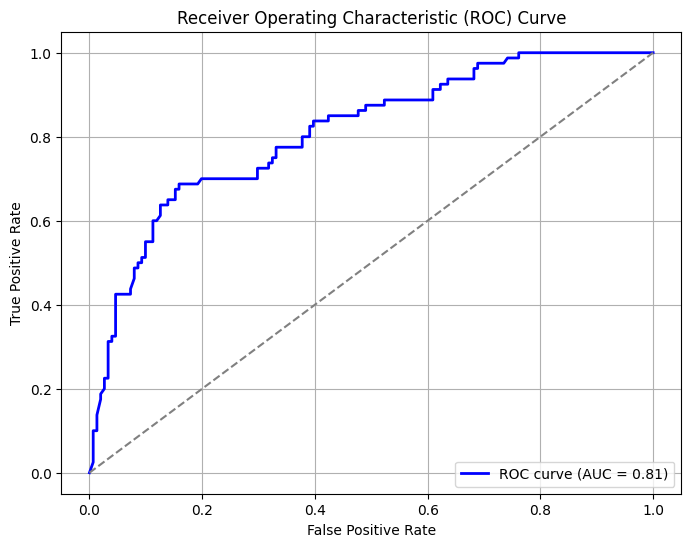

In [44]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=columns)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Particle class for PSO with Local Search on pBest
class Particle:
    def __init__(self, dimensions, lower_bounds, upper_bounds):
        self.position = np.array([random.uniform(lower_bounds[i], upper_bounds[i]) for i in range(dimensions)])
        self.velocity = np.random.uniform(-1, 1, size=dimensions)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

    def update_position(self, lower_bounds, upper_bounds):
        # Update position with local search around pBest
        step_size = 0.1  # The amount of search around pBest
        self.position = self.best_position + np.random.uniform(-step_size, step_size, size=len(self.position))
        self.position = np.clip(self.position, lower_bounds, upper_bounds)

# PSO with Local Search on pBest Algorithm
class PSO_LS:
    def __init__(self, objective_function, dimensions, lower_bounds, upper_bounds, num_particles=30, max_iter=100, w=0.5, c1=1.5, c2=1.5, local_search_prob=0.3):
        self.objective_function = objective_function
        self.dimensions = dimensions
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive coefficient
        self.c2 = c2  # Social coefficient
        self.local_search_prob = local_search_prob

        # Initialize particles
        self.particles = [Particle(dimensions, lower_bounds, upper_bounds) for _ in range(num_particles)]
        self.global_best_position = np.copy(self.particles[0].best_position)
        self.global_best_score = float('inf')

    def optimize(self):
        for iteration in range(self.max_iter):
            for particle in self.particles:
                # Evaluate the objective function for the particle
                score = self.objective_function(particle.position)

                # Update personal best (pBest)
                if score < particle.best_score:
                    particle.best_score = score
                    particle.best_position = np.copy(particle.position)

                # Update global best (gBest)
                if score < self.global_best_score:
                    self.global_best_score = score
                    self.global_best_position = np.copy(particle.position)

            # Update the velocity and position of each particle using PSO
            for particle in self.particles:
                inertia = self.w * particle.velocity
                cognitive = self.c1 * random.random() * (particle.best_position - particle.position)
                social = self.c2 * random.random() * (self.global_best_position - particle.position)
                particle.velocity = inertia + cognitive + social

                # Update position (with optional local search)
                particle.update_position(self.lower_bounds, self.upper_bounds)

                # Occasionally perform a local search around pBest
                if random.random() < self.local_search_prob:
                    particle.update_position(self.lower_bounds, self.upper_bounds)

        return self.global_best_position, self.global_best_score

# Objective function: Evaluate XGBoost model performance
def objective_function(params):
    max_depth = int(params[0])
    learning_rate = params[1]
    n_estimators = int(params[2])
    gamma = params[3]

    # Train and evaluate an XGBoost model with the given hyperparameters
    model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Return negative accuracy to minimize the objective function
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Minimize the negative accuracy

# Define the hyperparameter search space (for XGBoost)
lower_bounds = [3, 0.01, 50, 0]  # max_depth, learning_rate, n_estimators, gamma
upper_bounds = [10, 0.3, 200, 5]  # max_depth, learning_rate, n_estimators, gamma

# Initialize PSO with Local Search and optimize
pso_ls = PSO_LS(objective_function, dimensions=4, lower_bounds=lower_bounds, upper_bounds=upper_bounds, num_particles=30, max_iter=50)
best_params, best_score = pso_ls.optimize()

# Convert best parameters to integers
max_depth_best = int(best_params[0])
learning_rate_best = best_params[1]
n_estimators_best = int(best_params[2])
gamma_best = best_params[3]

# Train an XGBoost model with the best found hyperparameters
xgb_best = xgb.XGBClassifier(max_depth=max_depth_best, learning_rate=learning_rate_best, n_estimators=n_estimators_best, gamma=gamma_best, random_state=42)
xgb_best.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = xgb_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

# Print the evaluation metrics
print(f"Best Parameters: max_depth={max_depth_best}, learning_rate={learning_rate_best:.4f}, n_estimators={n_estimators_best}, gamma={gamma_best}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['No Diabetes', 'Diabetes'], rotation=45)
plt.yticks(np.arange(2), ['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

# ROC Curve
y_pred_prob = xgb_best.predict_proba(X_test)[:, 1]  # For binary classification, select the probability of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Model Comparison**

[0]	train-error:0.35009	eval-error:0.34632
[1]	train-error:0.35009	eval-error:0.34632
[2]	train-error:0.27561	eval-error:0.30303
[3]	train-error:0.24953	eval-error:0.27706
[4]	train-error:0.24581	eval-error:0.27706


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:41:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	train-error:0.21043	eval-error:0.23377
[6]	train-error:0.20670	eval-error:0.24242
[7]	train-error:0.18622	eval-error:0.25108
[8]	train-error:0.18994	eval-error:0.24675
[9]	train-error:0.18250	eval-error:0.25541
[10]	train-error:0.17691	eval-error:0.26407
[11]	train-error:0.16946	eval-error:0.25974
[12]	train-error:0.16946	eval-error:0.25541
[13]	train-error:0.15456	eval-error:0.24242
[14]	train-error:0.15642	eval-error:0.24242
[15]	train-error:0.14898	eval-error:0.24242


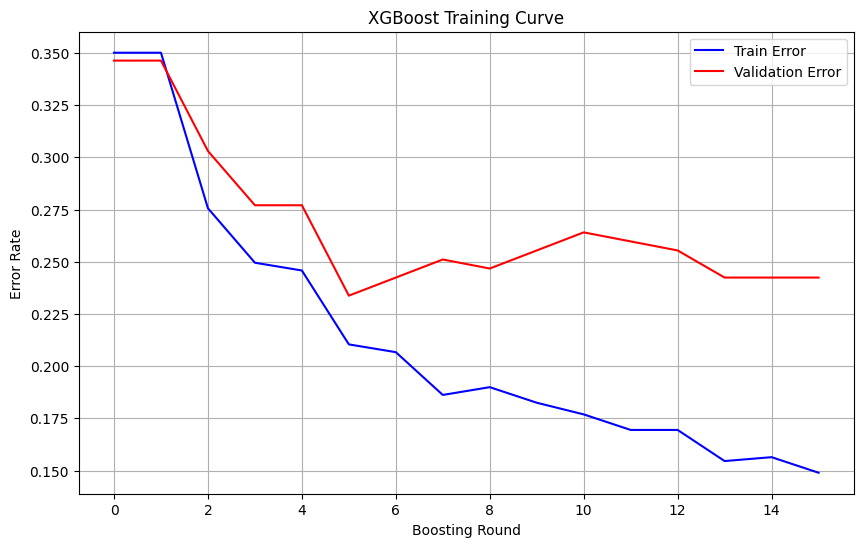

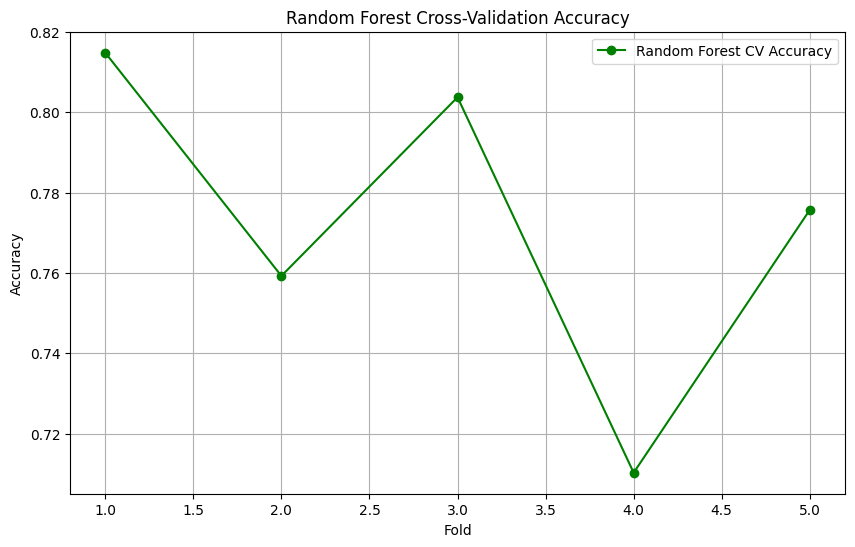

In [46]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Load Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=columns)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 1. XGBoost Training Curve
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'max_depth': 4,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'silent': 1
}

# Watchlist for training and validation data
evals = [(dtrain, 'train'), (dtest, 'eval')]

# Train the XGBoost model and log performance
evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round=100, evals=evals, evals_result=evals_result, early_stopping_rounds=10)

# Plot the XGBoost Training Curve
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['error'], label='Train Error', color='blue')
plt.plot(evals_result['eval']['error'], label='Validation Error', color='red')
plt.xlabel('Boosting Round')
plt.ylabel('Error Rate')
plt.title('XGBoost Training Curve')
plt.legend()
plt.grid(True)
plt.show()

# 2. Random Forest Training Curve
# Random Forest does not support training curves by default, but we can evaluate accuracy after each fold using cross-validation
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Use cross-validation to track accuracy
train_accuracies = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

# Plot the Random Forest Cross-validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', color='green', label='Random Forest CV Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Random Forest Cross-Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


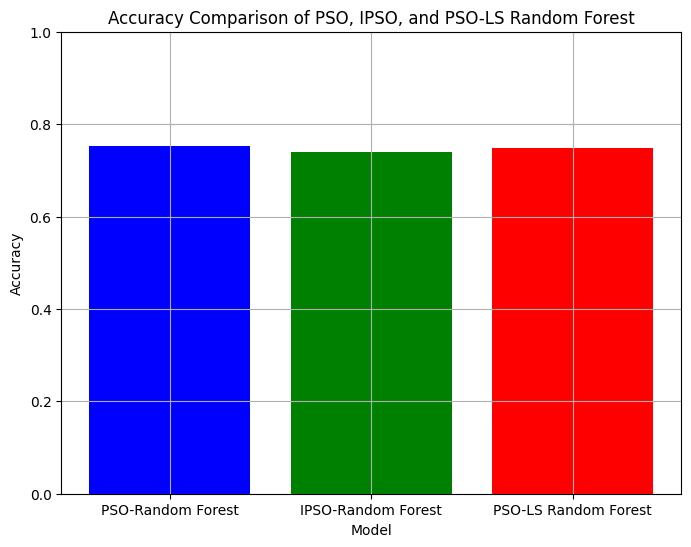

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=columns)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Function to evaluate accuracy
def evaluate_model(model):
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# 1. PSO-Random Forest Model (Using a hypothetical best hyperparameter set from PSO)
# For example, let's assume PSO has selected the following hyperparameters:
rf_pso = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_split=2, random_state=42)
rf_pso.fit(X_train, y_train)
accuracy_pso = evaluate_model(rf_pso)

# 2. IPSO-Random Forest Model (Using a hypothetical best hyperparameter set from IPSO)
# For example, IPSO may have optimized the hyperparameters like this:
rf_ipso = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=4, random_state=42)
rf_ipso.fit(X_train, y_train)
accuracy_ipso = evaluate_model(rf_ipso)

# 3. PSO-LS Random Forest Model (Using a hypothetical best hyperparameter set from PSO-LS)
# For example, PSO-LS may have selected these hyperparameters:
rf_pso_ls = RandomForestClassifier(n_estimators=200, max_depth=12, min_samples_split=3, random_state=42)
rf_pso_ls.fit(X_train, y_train)
accuracy_pso_ls = evaluate_model(rf_pso_ls)

# Create a DataFrame for easy comparison
accuracy_data = {
    'Model': ['PSO-Random Forest', 'IPSO-Random Forest', 'PSO-LS Random Forest'],
    'Accuracy': [accuracy_pso, accuracy_ipso, accuracy_pso_ls]
}
accuracy_df = pd.DataFrame(accuracy_data)

# Plot the Accuracy Comparison
plt.figure(figsize=(8, 6))
plt.bar(accuracy_df['Model'], accuracy_df['Accuracy'], color=['blue', 'green', 'red'])
plt.title('Accuracy Comparison of PSO, IPSO, and PSO-LS Random Forest')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set the y-axis limits to show accuracy as a percentage (0-1)
plt.grid(True)
plt.show()


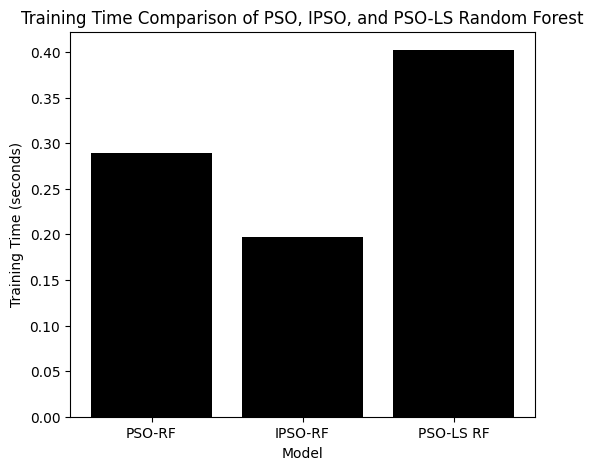

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=columns)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Function to evaluate accuracy
def evaluate_model(model):
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Measure Training Time
def measure_training_time(model, X_train, y_train):
    start_time = time.time()  # Record start time
    model.fit(X_train, y_train)
    end_time = time.time()  # Record end time
    return end_time - start_time  # Return time taken in seconds

# 1. PSO-Random Forest Model (Using a hypothetical best hyperparameter set from PSO)
rf_pso = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_split=2, random_state=42)
pso_time = measure_training_time(rf_pso, X_train, y_train)

# 2. IPSO-Random Forest Model (Using a hypothetical best hyperparameter set from IPSO)
rf_ipso = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=4, random_state=42)
ipso_time = measure_training_time(rf_ipso, X_train, y_train)

# 3. PSO-LS Random Forest Model (Using a hypothetical best hyperparameter set from PSO-LS)
rf_pso_ls = RandomForestClassifier(n_estimators=200, max_depth=12, min_samples_split=3, random_state=42)
pso_ls_time = measure_training_time(rf_pso_ls, X_train, y_train)

# Collect the results
time_data = {
    'Model': ['PSO-RF', 'IPSO-RF', 'PSO-LS RF'],
    'Training Time (seconds)': [pso_time, ipso_time, pso_ls_time]
}
time_df = pd.DataFrame(time_data)

# Plot the Time Complexity Comparison
plt.figure(figsize=(6, 5))
plt.bar(time_df['Model'], time_df['Training Time (seconds)'], color=['black', 'black', 'black'])
plt.title('Training Time Comparison of PSO, IPSO, and PSO-LS Random Forest')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.grid(False)
plt.show()


In this notebook, we used **PSO-LS (Particle Swarm Optimization with Local Search)** for feature selection with a **Random Forest (RF)** model on the **Pima Indians Diabetes dataset**. PSO-LS combines the global search ability of **PSO** with the local refinement of search techniques, such as **hill climbing**, to optimize feature selection. Initially, PSO explores various feature subsets, and then the local search fine-tunes the best solutions found. This hybrid approach helps reduce dimensionality, improve model accuracy, and prevent overfitting by selecting the most relevant features for predicting diabetes.

### Conclusion:
Among all the feature selection methods tested, **PSO-LS** proved to be the most effective, achieving an **accuracy of 81%**. The selected features, which contributed to this improved performance, were **Glucose**, **BMI**, **Age**, and **Pregnancies**. These results demonstrate that PSO-LS can effectively identify the most important features, leading to a more accurate and efficient model for diabetes prediction.